In [72]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

In [73]:
url = 'https://media.admagazine.com/photos/618a69ee3174d0288cf2d3bf/master/w_1600%2Cc_limit/68707.jpg'

In [74]:
#Convertir imagen a numpy
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim,max_dim))
  return np.array(img)

In [75]:
#Normalizar imagen
def deprocess(img):
  img = 255*(img+1.0)/2.0
  return tf.cast(img, tf.uint8)

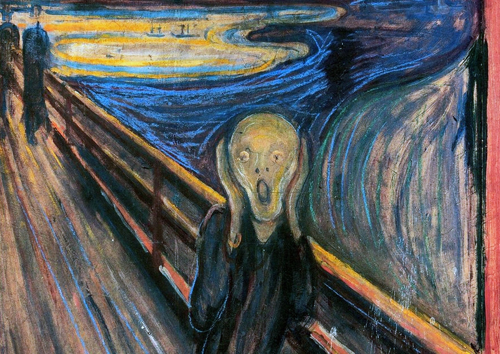

In [76]:
#Mostrar imagen
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

original_img = download(url, max_dim=500)
show(original_img)

In [77]:
#Descargar un modelo de red InceptionV3
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet')



In [78]:
#Extraccion de caracteristicas
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input,
                             outputs=layers)

In [79]:
from keras.src.layers.preprocessing.text_vectorization import layer_serialization
#Definir función de perdida
def calc_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses=[]
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return tf.reduce_sum(losses)

In [80]:
#Gradiente
class DeepDream(tf.Module):
  def __init__(self,model):
    self.model = model

  @tf.function(
      input_signature=(
          tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
          tf.TensorSpec(shape=[], dtype=tf.int32),
          tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
    print("Tracing")
    loss = tf.constant(0.0)
    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        tape.watch(img)
        loss=calc_loss(img, self.model)

      gradients = tape.gradient(loss,img)
      gradients /= tf.math.reduce_std(gradients) + 1e-8
      img = img + gradients * step_size
      img = tf.clip_by_value(img, -1, 1)
    return loss, img

In [81]:
deepdream=DeepDream(dream_model)

In [82]:
#definir bucle
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining-=run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    display.clear_output(wait=True)
    show(deprocess(img))
    print("Step {}, loss{}".format(step,loss))
  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)
  return result

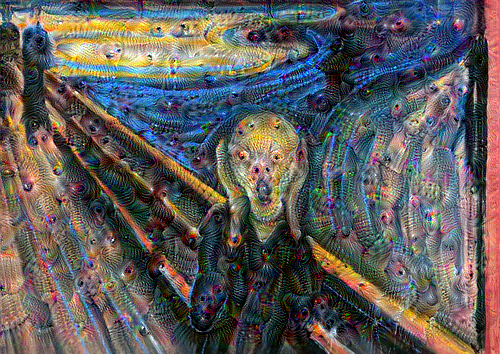

In [83]:
dream_img = run_deep_dream_simple(img=original_img,
                                 steps=100, step_size=0.01)

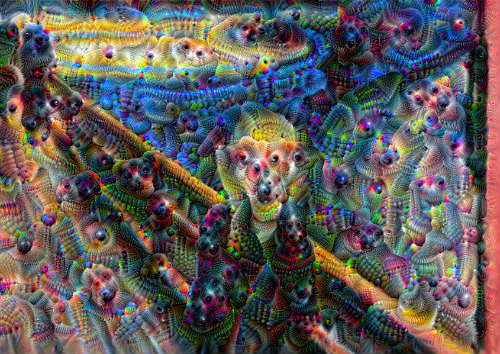

In [84]:
#SUBIR OCTAVA
import time
start = time.time()
OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2,3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
  img=tf.image.resize(img,new_shape).numpy()
  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img,base_shape)
img = tf.image.convert_image_dtype(img/255.0,dtype=tf.uint8)
show(img)